In [2]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [3]:


import os
path = "soja" # replace with your folder path
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

#define some parameters to the loader
batch_size = 32
img_height = 227
img_width = 227

5513


In [4]:
#Creating a list of images
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Creating the class list
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['Broken soybeans' 'Immature soybeans' 'Intact soybeans'
 'Skin-damaged soybeans' 'Spotted soybeans']


In [5]:
#splitting the dataset into train, test and validation sets
train_size = int(0.7 * image_count)
test_size = int(0.15 * image_count)

train_ds = list_ds.take(train_size)
test_ds = list_ds.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

print('Training size:', len(train_ds))
print('Validation size:', len(val_ds))
print('Test size:', len(test_ds))

Training size: 3859
Validation size: 828
Test size: 826


In [6]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


In [7]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

In [8]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [43]:
def inception_module(x,f):
  # branch with 1x1 conv
  branch1x1 = layers.Conv2D(f, 1, activation='leaky_relu')(x)
  branch3x3 = layers.Conv2D(f+16, 1, activation='leaky_relu')(x)
  branch3x3 = layers.Conv2D(f, 3, padding='same', activation='leaky_relu')(branch3x3)
  branch5x5 = layers.Conv2D(f, 1, activation='leaky_relu')(x)
  branch5x5 = layers.Conv2D(f+16, 5, padding='same', activation='leaky_relu')(branch5x5)  
  branchPol = layers.MaxPooling2D(3, strides=1, padding='same')(x)
  branchPol = layers.Conv2D(f+16, 1, activation='leaky_relu')(branchPol)
  output = layers.concatenate([branch1x1, branch3x3, branch5x5, branchPol], axis=3)
  return output

In [42]:
def Conv(x,f):
    convol = layers.Conv2D(f,(3,3),activation='leaky_relu')(x)
    rel = layers.PReLU()(convol)
    bn = layers.BatchNormalization()(rel)
    return bn

In [41]:
def adapt_learning_rate(epoch):
    return 0.001 * epoch

In [44]:

input_img = Input(shape=(227, 227, 3))  # Example input shape (224x224 RGB image)

# Apply initial convolution and max pooling
x = Conv(input_img,16)
x = layers.MaxPooling2D((3, 3))(x)
x = Conv(x,32)
x = layers.MaxPooling2D((3, 3))(x)
# Apply the Inception module
x = inception_module(x,64)
x = inception_module(x,96)
x = layers.MaxPooling2D((3, 3))(x)
x = inception_module(x,128)
x = layers.MaxPooling2D((3, 3))(x)
x = inception_module(x,156)
x = layers.AveragePooling2D((1,1),padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(len(class_names), activation='softmax')(x) 

# Create the model
model = Model(inputs=input_img, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_290 (Conv2D) │ (None, 225, 225,  │        448 │ input_layer_12[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_16 (PReLU)  │ (None, 225, 225,  │    810,000 │ conv2d_290[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 225, 225,  │         64 │ p_re_lu_16[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_90    │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_291 (Conv2D) │ (None, 73, 73,    │      4,640 │ max_pooling2d_90… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_17 (PReLU)  │ (None, 73, 73,    │    170,528 │ conv2d_291[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        128 │ p_re_lu_17[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_91    │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_293 (Conv2D) │ (None, 24, 24,    │      2,640 │ max_pooling2d_91… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_295 (Conv2D) │ (None, 24, 24,    │      2,112 │ max_pooling2d_91… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_92    │ (None, 24, 24,    │          0 │ max_pooling2d_91… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_292 (Conv2D) │ (None, 24, 24,    │      2,112 │ max_pooling2d_91… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_294 (Conv2D) │ (None, 24, 24,    │     46,144 │ conv2d_293[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_296 (Conv2D) │ (None, 24, 24,    │    128,080 │ conv2d_295[0][0]  │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_297 (Conv2D) │ (None, 24, 24,    │      2,640 │ max_pooling2d_92… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_44      │ (None, 24, 24,    │          0 │ conv2d_292[0][0]

 Total params: 5,126,045 (19.55 MB)

 Trainable params: 5,125,949 (19.55 MB)

 Non-trainable params: 96 (384.00 B)

In [45]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


C:\Users\bruno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


121/121 ━━━━━━━━━━━━━━━━━━━━ 118s 882ms/step - accuracy: 0.4168 - loss: 2.6054 - val_accuracy: 0.5688 - val_loss: 1.1899
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 101s 831ms/step - accuracy: 0.7448 - loss: 0.6883 - val_accuracy: 0.8019 - val_loss: 0.5423
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 101s 833ms/step - accuracy: 0.8127 - loss: 0.5015 - val_accuracy: 0.7198 - val_loss: 0.7494
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 102s 841ms/step - accuracy: 0.8245 - loss: 0.4646 - val_accuracy: 0.7717 - val_loss: 0.6534
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 101s 833ms/step - accuracy: 0.8593 - loss: 0.3832 - val_accuracy: 0.8019 - val_loss: 0.5258
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 100s 827ms/step - accuracy: 0.8916 - loss: 0.2972 - val_accuracy: 0.8321 - val_loss: 0.4614
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 100s 829ms/step - accuracy: 0.8980 - loss: 0.2729 - val_accuracy: 0.7754 - val_loss: 0.6648
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 101s 833ms/step - accuracy: 0.9314 - loss: 0.19

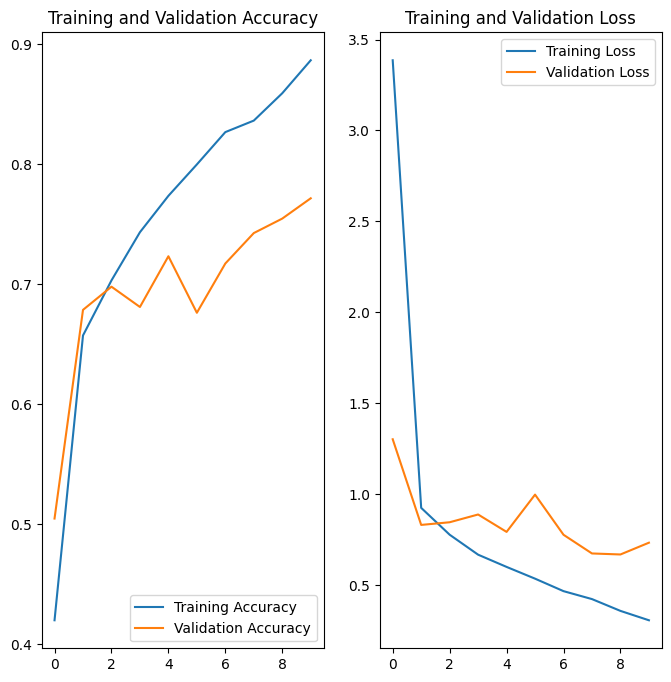

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
scores = model.evaluate(test_ds, verbose = 0)
print(scores[1])


0.8595641851425171
